In [2]:
import csv
import numpy as np
import mpmath as mp #problem with mp!
import matplotlib.pyplot as plt
from scipy.integrate import simps,cumtrapz
import astropy.cosmology as co
import astropy.units as u
import astropy.constants as const
import pandas as pd

In [3]:
#%config InlineBackend.figure_format = 'retina'
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fontSz = 15
fontsz = 13
fontssz = 11

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        if int(base)==1:
            return r"10^{{{0}}}".format(int(exponent))
        if int(base)==-1:
            return r"-10^{{{0}}}".format(int(exponent))
        else:
            return r"{0} \cdot 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str
    
print('latex test: '+latex_float(1.0e9), latex_float(-1e-9))

latex test: 10^{9} -10^{-9}


In [4]:
H0kmsMpc = 70*u.km/u.s/u.Mpc
cosmo = co.FlatLambdaCDM(H0kmsMpc,0.307)
def tau_einst_int(z_s):
    ''' standard lensing optical depth integral (dimensionless)'''
    z_p = np.linspace(1e-3*z_s,z_s,100)
    DL = cosmo.angular_diameter_distance(z_p)
    DLS = cosmo.angular_diameter_distance_z1z2(z_p,z_s*np.ones(len(z_p)))
    DS = cosmo.angular_diameter_distance(z_s)
    #convert by hand
    H = cosmo.H(z_p)/(3e5*u.km/u.s)
    H0 = cosmo.H(0)/(3e5*u.km/u.s)
    integrand = H0**2*(1+z_p)**2/H*(DL*DLS/DS)
    return simps(integrand,x=z_p)

tau_einst_int = np.vectorize(tau_einst_int)

def tau_phys_int(z_s):
    '''optical depth integral for fix physical radius (not comoving)'''
    z_p = np.linspace(1e-3*z_s,z_s,100)
    #DL = cosmo.angular_diameter_distance(z_p)
    #DLS = cosmo.angular_diameter_distance_z1z2(z_p,z_s)
    #DS = cosmo.angular_diameter_distance(z_s)
    #convert by hand
    H = cosmo.H(z_p)/(3e5*u.km/u.s)
    H0 = cosmo.H(0)/(3e5*u.km/u.s)
    integrand = H0*(1+z_p)**2/H
    return simps(integrand,x=z_p)

tau_phys_int = np.vectorize(tau_phys_int)

def dL2z(dL,zmax=2):
    ''' return z for a given d_L, cosmo is an astropy cosmology class'''
    zs = np.geomspace(1e-2,zmax,100)
    dLs = cosmo.luminosity_distance(zs)
    
    #z = griddata(dLs,zs,dL)
    z=np.interp(dL,dLs.value,zs)
    return z

In [5]:
dL=200
zs = np.geomspace(1e-2,2,100)
dLs = cosmo.luminosity_distance(zs)
    
    #z = griddata(dLs,zs,dL)
z=np.interp(dL,dLs.value,zs)

In [6]:
events_df_info=pd.read_csv('data/events_df_info.csv')
events_df_info.tail()

Unnamed: 0  Unnamed: 0.1 CatDev Name     SNAME         FULLNAME  \
83          83            83   GW200308A  S200308a  GW200308_173609   
84          84            84   GW200311B  S200311b  GW200311_115853   
85          85            85   GW200316A  S200316a  GW200316_215756   
86          86            86   GW200322A  S200322a  GW200322_091133   
87          87            87   GW200326A  S200326a  GW200326_112501   

              NNAME  MINIMALNAME GRACEDBSID  IS PUBLIC?  CWB ONLY?  ...  \
83  GW200308_173609     GW200308  S200308bl       False      False  ...   
84  GW200311_115853  GW200311_11  S200311bg        True      False  ...   
85  GW200316_215756     GW200316  S200316bj        True      False  ...   
86  GW200322_091133     GW200322  S200322ab       False      False  ...   
87  GW200326_112501     GW200326  S200326af       False       True  ...   

     mass2 L1  mchirp L1   mtotal L1  template_duration L1    snr V1  \
83  34.847599  41.906761  102.818770              4.399324  2.133489   
84  32.121094  29.053270   66.805939              2.704791  7.292044   
85   4.943711  10.775739   41.868874             11.333138  3.119627   
86  15.137034  24.386002   71.318713              0.720487  2.242833   
87        NaN        NaN         NaN                   NaN       NaN   

     mass1 V1   mass2 V1  mchirp V1   mtotal V1  template_duration V1  
83  67.971169  34.847599  41.906761  102.818770              4.399324  
84  34.684841  32.121094  29.053270   66.805939              2.704791  
85  36.925163   4.943711  10.775739   41.868874             11.333138  
86  56.181679  15.137034  24.386002   71.318713              0.720487  
87        NaN        NaN        NaN         NaN                   NaN  

[5 rows x 30 columns]

In [7]:
dict_grace_fullname = dict(zip(events_df_info['NNAME'],events_df_info['GRACEDBSID']))
#dict_grace_fullname

In [31]:
reader=pd.read_csv('data/gwtc_27oct.csv')
reader = reader[reader['luminosity_distance'].notna()].reset_index(drop=True)
#print(gw_z_data)
subcatalogue = []
subcat_zs = []
print ('name' , 'luminosity_distance', 'z', 'network_matched_filter_snr')
reader=reader[reader['far']<1e-3][:].reset_index(drop=True)
for i in range(len(reader)):
    row = reader.loc[i]
    if 1:#row['commonName']  in events_tested:
        subcatalogue.append(row)
        z = dL2z(np.float64(row['luminosity_distance']))
        subcat_zs.append(z)
        print (row['commonName'] , row['luminosity_distance'], '%.3g'%z, '%.4g'%float(row['network_matched_filter_snr']))

factor = 3 #factor at which the exclusion can be placed, from poisson statistics CDF = exp(-tau) = 0.05
#subcatalogue and associated fiducials
subcat_zs = np.array(subcat_zs)
tau_phys=tau_phys_int(subcat_zs)
#print ('tau_phys (R_x=22_kpc)', np.sum(tau_phys))
tau_einst=tau_einst_int(subcat_zs)
#print('tau_einst (alpha=1)', np.sum(tau_einst))

Om = 0.3 #Omega_m
h = 0.7

RX_O2_kpc = 22./np.sqrt(np.sum(h*Om*tau_phys)/factor)
alphaX_O2 = 1/np.sqrt(np.sum(1.5*Om*tau_einst)/factor)
print('-----------------------------------------')
print ('RX > %.3g'%RX_O2_kpc, 'kpc excluded (95%)', ' tau_tot = %.3g'%np.sum(tau_phys))
print ('alphaX > %.3g'%alphaX_O2, ' excluded (95%)', 'tau_tot = %.3g'%np.sum(tau_einst))

name luminosity_distance z network_matched_filter_snr
GW150914 440.0 0.0959 26
GW151226 450.0 0.0979 13.1
GW170104 990.0 0.202 13.8
GW170608 320.0 0.0709 15.4
GW170809 1030.0 0.209 12.8
GW170814 600.0 0.128 17.7
GW170817 40.0 0.01 33
GW170818 1060.0 0.215 12
GW170823 1940.0 0.364 12.2
GW190408_181802 1540.0 0.298 14.6
GW190412 720.0 0.151 19.8
GW190503_185404 1520.0 0.295 12.2
GW190512_180714 1460.0 0.285 12.7
GW190513_205428 2210.0 0.407 12.5
GW190517_055101 1790.0 0.34 10.8
GW190519_153544 2600.0 0.466 15.9
GW190521_074359 1080.0 0.218 25.9
GW190602_175927 2840.0 0.502 13.2
GW190630_185205 870.0 0.18 16.4
GW190706_222641 3630.0 0.615 13.4
GW190707_093326 850.0 0.176 13.1
GW190708_232457 930.0 0.191 13.4
GW190720_000836 770.0 0.161 10.9
GW190727_060333 3070.0 0.536 11.7
GW190728_064510 880.0 0.182 13.1
GW190814 230.0 0.0517 25.3
GW190828_063405 2070.0 0.385 16.5
GW190828_065509 1540.0 0.298 10.2
GW190915_235702 1750.0 0.333 13.1
GW190924_021846 550.0 0.118 12
GW191109_010717 1290.0 0.

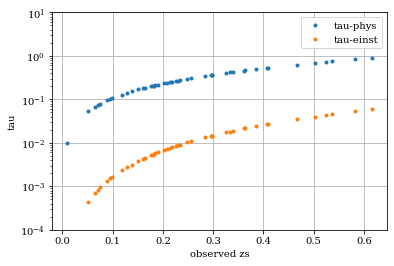

In [32]:
import matplotlib.pylab as plt
plt.plot(subcat_zs,tau_phys,'.',label='tau-phys')
plt.plot(subcat_zs,tau_einst,'.',label='tau-einst')
plt.yscale('log')
plt.ylim(1e-4,1e1)
plt.legend()
plt.xlabel('observed zs')
plt.ylabel('tau')
plt.grid()
plt.show()


In [33]:
np.sum(tau_phys)

14.645323686439804

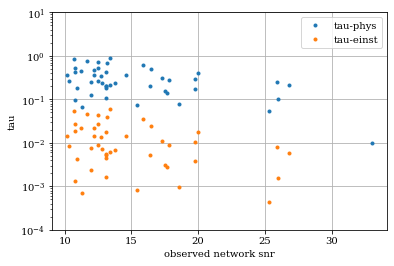

In [34]:
plt.plot(reader['network_matched_filter_snr'],tau_phys,'.',label='tau-phys')
plt.plot(reader['network_matched_filter_snr'],tau_einst,'.',label='tau-einst')
plt.yscale('log')
plt.ylim(1e-4,1e1)
plt.legend()
plt.xlabel('observed network snr')
plt.ylabel('tau')
plt.grid()
plt.show()



In [35]:
events_to_consider = reader[reader['far']<1e-3].reset_index(drop=True)['commonName'].values
events_to_consider

array(['GW150914', 'GW151226', 'GW170104', 'GW170608', 'GW170809',
       'GW170814', 'GW170817', 'GW170818', 'GW170823', 'GW190408_181802',
       'GW190412', 'GW190503_185404', 'GW190512_180714',
       'GW190513_205428', 'GW190517_055101', 'GW190519_153544',
       'GW190521_074359', 'GW190602_175927', 'GW190630_185205',
       'GW190706_222641', 'GW190707_093326', 'GW190708_232457',
       'GW190720_000836', 'GW190727_060333', 'GW190728_064510',
       'GW190814', 'GW190828_063405', 'GW190828_065509',
       'GW190915_235702', 'GW190924_021846', 'GW191109_010717',
       'GW191129_134029', 'GW191204_171526', 'GW191215_223052',
       'GW191216_213338', 'GW191222_033537', 'GW200112_155838',
       'GW200115_042309', 'GW200129_065458', 'GW200202_154313',
       'GW200208_130117', 'GW200219_094415', 'GW200224_222234',
       'GW200225_060421', 'GW200311_115853', 'GW200316_215756'],
      dtype=object)

In [36]:
len(events_to_consider)

46

In [37]:
analysed_events = np.array(['GW190521', 'GW190910_112807', 'GW170823', 'GW191109_010717',
       'GW191129_134029', 'GW190512_180714', 'GW200219_094415',
       'GW190630_185205', 'GW190828_065509', 'GW200225_060421',
       'GW170729', 'GW190915_235702', 'GW190517_055101',
       'GW190513_205428', 'GW190421_213856', 'GW191215_223052',
       'GW190708_232457', 'GW190519_153544', 'GW170809', 'GW151012',
       'GW200112_155838', 'GW151226', 'GW190408_181802',
       'GW190706_222641', 'GW191222_033537', 'GW190828_063405',
       'GW170814', 'GW190707_093326', 'GW190503_185404', 'GW170104',
       'GW190521_074359', 'GW190727_060333', 'GW200208_130117',
       'GW170818', 'GW150914', 'GW190602_175927', 'GW200224_222234',
       'GW190720_000836', 'GW200311_115853', 'GW191216_213338',
       'GW200129_065458', 'GW200202_154313', 'GW200316_215756'])

In [41]:
reader=pd.read_csv('data/gwtc_27oct.csv')


In [58]:
reader['chirp_mass'] = reader['chirp_mass_source']*(1+reader['redshift'])

In [59]:
reader.set_index('commonName').loc[analysed_events]

id  version   catalog.shortName  \
commonName                                                         
GW190521         GW190521_030229-v4        4  GWTC-2.1-confident   
GW190910_112807  GW190910_112807-v2        2  GWTC-2.1-confident   
GW170823                GW170823-v1        1    GWTC-1-confident   
GW191109_010717  GW191109_010717-v1        1    GWTC-3-confident   
GW191129_134029  GW191129_134029-v1        1    GWTC-3-confident   
GW190512_180714  GW190512_180714-v2        2  GWTC-2.1-confident   
GW200219_094415  GW200219_094415-v1        1    GWTC-3-confident   
GW190630_185205  GW190630_185205-v2        2  GWTC-2.1-confident   
GW190828_065509  GW190828_065509-v2        2  GWTC-2.1-confident   
GW200225_060421  GW200225_060421-v1        1    GWTC-3-confident   
GW170729                GW170729-v1        1    GWTC-1-confident   
GW190915_235702  GW190915_235702-v2        2  GWTC-2.1-confident   
GW190517_055101  GW190517_055101-v2        2  GWTC-2.1-confident   
GW190513_205428  GW190513_205428-v2        2  GWTC-2.1-confident   
GW190421_213856  GW190421_213856-v2        2  GWTC-2.1-confident   
GW191215_223052  GW191215_223052-v1        1    GWTC-3-confident   
GW190708_232457  GW190708_232457-v2        2  GWTC-2.1-confident   
GW190519_153544  GW190519_153544-v2        2  GWTC-2.1-confident   
GW170809                GW170809-v1        1    GWTC-1-confident   
GW151012                GW151012-v3        3    GWTC-1-confident   
GW200112_155838  GW200112_155838-v1        1    GWTC-3-confident   
GW151226                GW151226-v2        2    GWTC-1-confident   
GW190408_181802  GW190408_181802-v2        2  GWTC-2.1-confident   
GW190706_222641  GW190706_222641-v2        2  GWTC-2.1-confident   
GW191222_033537  GW191222_033537-v1        1    GWTC-3-confident   
GW190828_063405  GW190828_063405-v2        2  GWTC-2.1-confident   
GW170814                GW170814-v3        3    GWTC-1-confident   
GW190707_093326  GW190707_093326-v2        2  GWTC-2.1-confident   
GW190503_185404  GW190503_185404-v2        2  GWTC-2.1-confident   
GW170104                GW170104-v2        2    GWTC-1-confident   
GW190521_074359  GW190521_074359-v2        2  GWTC-2.1-confident   
GW190727_060333  GW190727_060333-v2        2  GWTC-2.1-confident   
GW200208_130117  GW200208_130117-v1        1    GWTC-3-confident   
GW170818                GW170818-v1        1    GWTC-1-confident   
GW150914                GW150914-v3        3    GWTC-1-confident   
GW190602_175927  GW190602_175927-v2        2  GWTC-2.1-confident   
GW200224_222234  GW200224_222234-v1        1    GWTC-3-confident   
GW190720_000836  GW190720_000836-v2        2  GWTC-2.1-confident   
GW200311_115853  GW200311_115853-v1        1    GWTC-3-confident   
GW191216_213338  GW191216_213338-v1        1    GWTC-3-confident   
GW200129_065458  GW200129_065458-v1        1    GWTC-3-confident   
GW200202_154313  GW200202_154313-v1        1    GWTC-3-confident   
GW200316_215756  GW200316_215756-v1        1    GWTC-3-confident   

                          GPS                          reference  \
commonName                                                         
GW190521         1.242443e+09                         /GWTC-2.1/   
GW190910_112807  1.252150e+09                         /GWTC-2.1/   
GW170823         1.187529e+09  https://doi.org/10.7935/82H3-HH23   
GW191109_010717  1.257297e+09                           /GWTC-3/   
GW191129_134029  1.259070e+09                           /GWTC-3/   
GW190512_180714  1.241720e+09                         /GWTC-2.1/   
GW200219_094415  1.266141e+09                           /GWTC-3/   
GW190630_185205  1.245956e+09                         /GWTC-2.1/   
GW190828_065509  1.251011e+09                         /GWTC-2.1/   
GW200225_060421  1.266646e+09                           /GWTC-3/   
GW170729         1.185390e+09  https://doi.org/10.7935/82H3-HH23   
GW190915_235702  1.252627e+09                         /GWTC-2.1/   
GW190517_055101  1.2

In [65]:
reader.set_index('commonName').loc[analysed_events]['mass_2_source']

commonName
GW190521           57.2
GW190910_112807    34.2
GW170823           29.0
GW191109_010717    47.0
GW191129_134029     6.7
GW190512_180714    12.5
GW200219_094415    27.9
GW190630_185205    24.0
GW190828_065509    10.4
GW200225_060421    14.0
GW170729           34.0
GW190915_235702    24.5
GW190517_055101    24.0
GW190513_205428    18.3
GW190421_213856    32.0
GW191215_223052    18.1
GW190708_232457    11.6
GW190519_153544    40.8
GW170809           23.8
GW151012           13.6
GW200112_155838    28.3
GW151226            7.7
GW190408_181802    18.5
GW190706_222641    39.4
GW191222_033537    34.7
GW190828_063405    25.8
GW170814           25.2
GW190707_093326     7.9
GW190503_185404    28.3
GW170104           20.0
GW190521_074359    33.4
GW190727_060333    30.2
GW200208_130117    27.4
GW170818           26.7
GW150914           30.6
GW190602_175927    44.8
GW200224_222234    32.5
GW190720_000836     7.5
GW200311_115853    27.7
GW191216_213338     7.7
GW200129_065458    28.9
GW200

In [61]:
remaining=np.setdiff1d(events_to_consider,analysed_events)
remaining

array(['GW170608', 'GW170817', 'GW190412', 'GW190728_064510', 'GW190814',
       'GW190924_021846', 'GW191204_171526', 'GW200115_042309'],
      dtype=object)

In [66]:
reader.set_index('commonName').loc[remaining]['mass_2_source']

commonName
GW170608           7.60
GW170817           1.27
GW190412           9.00
GW190728_064510    8.00
GW190814           2.60
GW190924_021846    5.10
GW191204_171526    8.20
GW200115_042309    1.44
Name: mass_2_source, dtype: float64

In [40]:
(', ').join(events_to_consider)

'GW150914, GW151226, GW170104, GW170608, GW170809, GW170814, GW170817, GW170818, GW170823, GW190408_181802, GW190412, GW190503_185404, GW190512_180714, GW190513_205428, GW190517_055101, GW190519_153544, GW190521_074359, GW190602_175927, GW190630_185205, GW190706_222641, GW190707_093326, GW190708_232457, GW190720_000836, GW190727_060333, GW190728_064510, GW190814, GW190828_063405, GW190828_065509, GW190915_235702, GW190924_021846, GW191109_010717, GW191129_134029, GW191204_171526, GW191215_223052, GW191216_213338, GW191222_033537, GW200112_155838, GW200115_042309, GW200129_065458, GW200202_154313, GW200208_130117, GW200219_094415, GW200224_222234, GW200225_060421, GW200311_115853, GW200316_215756'

# approximate expected results

## all gwtc events
RX > 12.2 kpc excluded (95%)  tau_tot = 46.4

alphaX > 1.56  excluded (95%) tau_tot = 2.74


## events having FAR <1e-3

RX > 20.2 kpc excluded (95%)  tau_tot = 16.9

alphaX > 2.92  excluded (95%) tau_tot = 0.782
